### My work over the 2nd chapter of the book "Learn Algorithmic Trading" by Donadio & Ghosh.

In [29]:
import pandas as pd
from pandas_datareader import data as pd_data

# Designing a Trading Strategy based on trend and momentum-based indicators:

## Suport and Resistence Indicators:

In [30]:
start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME = 'goog_data.pkl'

try:
    goog_data2 = pd.read_pickle(SRC_DATA_FILENAME)
    print('File found...')
except FileNotFoundError:
    print('File Not Found! Downloading the data and creating the file...')
    goog_data2 = pd_data.DataReader('GOOG', 'yahoo', start_date, end_date)
    goog_data2.to_pickle(SRC_DATA_FILENAME)

File found...


In [31]:
goog_data = goog_data2.tail(620) # pick the 620 most recent observations
lows = goog_data["Low"]
highs = goog_data["High"]

#print(lows.head(),"\n\n")
#print(highs.head())
goog_data.head(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-07-17,674.468018,645.000000,649.000000,672.929993,11164900.0,672.929993
2015-07-20,668.880005,653.010010,659.239990,663.020020,5860900.0,663.020020
2015-07-21,673.000000,654.299988,655.210022,662.299988,3377200.0,662.299988


In [32]:
import matplotlib.pyplot as plt

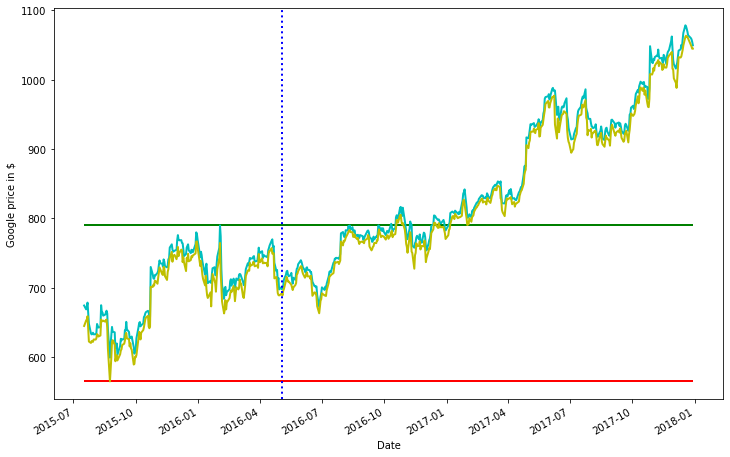

In [60]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')

highs.plot(ax=ax1, color='c', lw=2.)
lows.plot(ax=ax1, color='y', lw=2.)

plt.hlines(highs.head(200).max(), highs.index.values[0], highs.index.values[-1], linewidth=2, color='g')
plt.hlines(lows.head(200).min(), lows.index.values[0], lows.index.values[-1], linewidth=2, color='r')

plt.axvline(linewidth=2, color='b', x=lows.index.values[200], linestyle=':')

zoom = 2.0
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

plt.show()

In our example, we can introduce two further parameters:
* The minimum number of times that a price needs to reach the support/resistance level.
* We will define the tolerance margin of what we consider being close to the support/resistance level.

In [34]:
import numpy as np

In [35]:
goog_data_signal = pd.DataFrame(index=goog_data.index)
goog_data_signal.tail(3)

""
Date
2017-12-27
2017-12-28
2017-12-29


In [36]:
goog_data_signal['price'] = goog_data['Adj Close']
goog_data_signal.tail(3)

,price
Date,
2017-12-27,1049.369995
2017-12-28,1048.140015
2017-12-29,1046.400024


Implementing the trading strategy:

In [37]:
def trading_support_resistance(df, bin_width=20): # 20 is the rolling window, the memory of the support and resistance...
    df['sup_tolerance'] = pd.Series(np.zeros(len(df)))
    df['res_tolerance'] = pd.Series(np.zeros(len(df)))
    df['sup_count'] = pd.Series(np.zeros(len(df)))
    df['res_count'] = pd.Series(np.zeros(len(df)))
    df['sup'] = pd.Series(np.zeros(len(df)))
    df['res'] = pd.Series(np.zeros(len(df)))
    df['positions'] = pd.Series(np.zeros(len(df)))
    df['signal'] = pd.Series(np.zeros(len(df)))
    in_support = 0
    in_resistance = 0
    
    TOLERANCE = 0.2
    
    for x in range((bin_width-1) + bin_width, len(df)):
        df_section = df[x - bin_width:x + 1]
        support_level = min(df_section['price'])
        resistance_level = max(df_section['price'])
        range_level = resistance_level - support_level
        df['res'][x] = resistance_level
        df['sup'][x] = support_level
        df['sup_tolerance'][x] = support_level + TOLERANCE*range_level
        df['res_tolerance'][x] = resistance_level - TOLERANCE*range_level
        
        if df['price'][x] >= df['res_tolerance'][x] and df['price'][x] <= df['res'][x]:
            in_resistance += 1
            df['res_count'][x] = in_resistance
        elif df['price'][x] <= df['sup_tolerance'][x] and df['price'][x] >= df['sup'][x]:
            in_support += 1
            df['sup_count'][x] = in_support
        else:
            in_support = 0
            in_resistance = 0
        
        if in_resistance > 2:
            df['signal'][x] = 1
        elif in_support > 2:
            df['signal'][x] = 0
        else:
            df['signal'][x] = df['signal'][x-1]
    
    df['positions'] = df['signal'].diff()

trading_support_resistance(goog_data_signal)
goog_data_signal

,price,sup_tolerance,res_tolerance,sup_count,res_count,sup,res,positions,signal
Date,,,,,,,,,
2015-07-17,672.929993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-20,663.020020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-21,662.299988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-22,662.099976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-23,644.280029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2017-12-22,1060.119995,1014.371997,1061.44801,NaN,NaN,998.679993,1077.140015,0.0,1.0
2017-12-26,1056.739990,1014.371997,1061.44801,NaN,NaN,998.679993,1077.140015,0.0,1.0
2017-12-27,1049.369995,1014.371997,1061.44801,NaN,NaN,998.679993,1077.140015,0.0,1.0


In [38]:
goog_data_signal.tail()

,price,sup_tolerance,res_tolerance,sup_count,res_count,sup,res,positions,signal
Date,,,,,,,,,
2017-12-22,1060.119995,1014.371997,1061.44801,NaN,NaN,998.679993,1077.140015,0.0,1.0
2017-12-26,1056.739990,1014.371997,1061.44801,NaN,NaN,998.679993,1077.140015,0.0,1.0
2017-12-27,1049.369995,1014.371997,1061.44801,NaN,NaN,998.679993,1077.140015,0.0,1.0
2017-12-28,1048.140015,1014.371997,1061.44801,NaN,NaN,998.679993,1077.140015,0.0,1.0
2017-12-29,1046.400024,1014.371997,1061.44801,NaN,NaN,998.679993,1077.140015,0.0,1.0


Plotting the chart with the time the orders go out:

In [39]:
import matplotlib.pyplot as plt

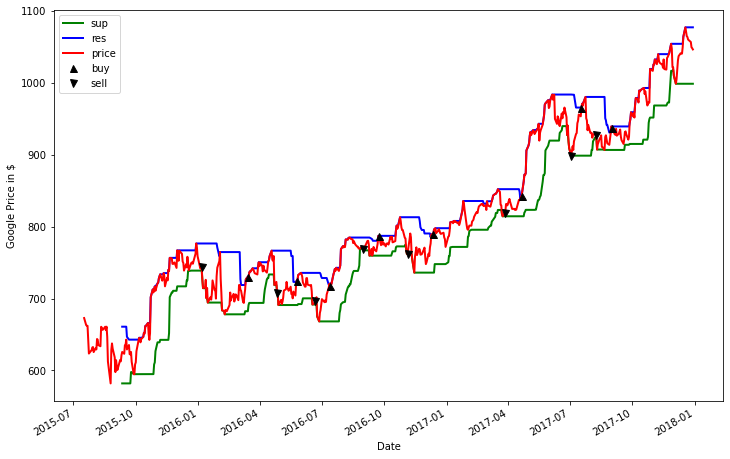

In [40]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google Price in $')
goog_data_signal['sup'].plot(ax=ax1, color='g', lw=2.)
goog_data_signal['res'].plot(ax=ax1, color='b', lw=2.)
goog_data_signal['price'].plot(ax=ax1, color='r', lw=2.)
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == 1.0].index, 
         goog_data_signal.price[goog_data_signal.positions == 1.0], 
         '^', markersize=7, color='k', label='buy')
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == -1.0].index, 
         goog_data_signal.price[goog_data_signal.positions == -1.0], 
         'v', markersize=7, color='k', label='sell')

zoom = 2.0
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

plt.legend()
plt.show()

# Creating trading signals based on Fundamental Technical Analysis:
* Simple Moving Average (SMA);
* Exponantial Moving Average (EMA);
* Absolute Price Oscilator (APO);
* Moving Average Convergence Divergence (MACD);
* Bollinger Bands (BBANDS);
* Relative Strngth Indicator (RSI);
* Standard Deviation (STDEV);
* Momentum (MOM).

### Implementation of the Simple Moving Average (SMA):

In [41]:
import statistics as stats

In [42]:
close = goog_data['Close']

time_period = 20 # number of days over which to average
history = [] # will store the last 20 prices, when
sma_values = [] # to track simple moving average values
for close_price in close:
    history.append(close_price)
    if len(history) > time_period: # we remove oldest price because we only average over last 'time_period' prices
        del (history[0]) # it will start deleting when the number of observations is greater than 'time_period'
    sma_values.append(stats.mean(history))

# creating new columns in the 'goog_data' DataFrame
goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(Simple20DayMovingAverage=pd.Series(sma_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
sma = goog_data['Simple20DayMovingAverage']

... Now Plotting ...

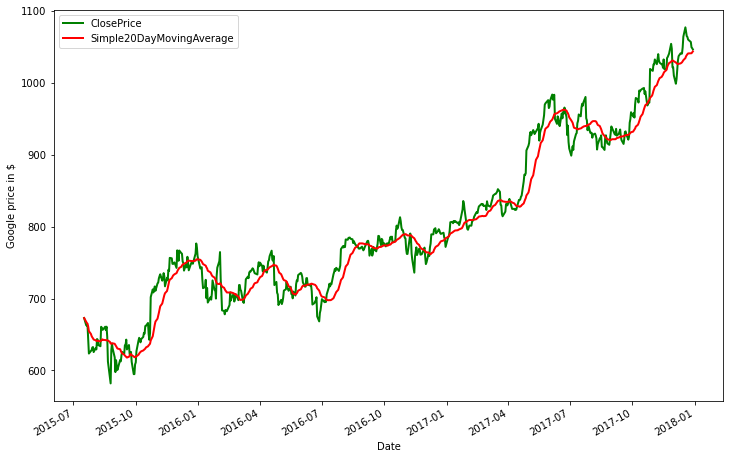

In [43]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')

close_price.plot(ax=ax1, color='g', lw=2., legend=True)
sma.plot(ax=ax1, color='r', lw=2., legend=True)

zoom = 2.0
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

plt.show()

### Implementation of the Exponential Moving Average (EMA):

All the EMA logic is in the following cell:

In [44]:
num_periods = 20 # number of days over which to average
K = 2 / (num_periods + 1) # smoothing constant
ema_p = 0

ema_values = [] # to hold computed EMA values
for close_price in close:
    if (ema_p == 0): # first observation, EMA = current-price
        ema_p = close_price
    else:
        ema_p = (close_price - ema_p) * K + ema_p

    ema_values.append(ema_p)

In [45]:
goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(Exponential20DayMovingAverage=pd.Series(ema_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
ema = goog_data['Exponential20DayMovingAverage']

Ploting the EMA:

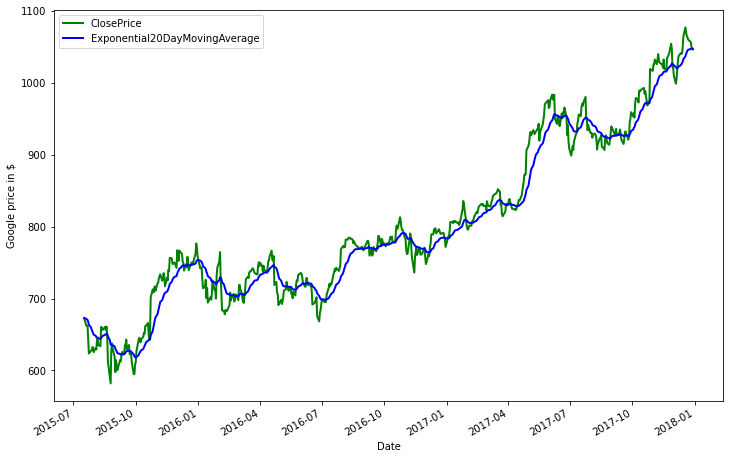

In [46]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')

close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema.plot(ax=ax1, color='b', lw=2., legend=True)

zoom = 2.0
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

plt.show()

### Implementation of the Absolute Price Oscillator (APO):
APO is built on top of the EMA: $ APO = EMA_{fast} - EMA_{slow} $. That is, APO is the difference between a short-time-period EMA and a long-time-period EMA.

All the APO logic is in the cell bellow:

In [47]:
num_periods_fast = 10 # time period for the fast EMA
K_fast = 2 / (num_periods_fast + 1) # smoothing factor for fast EMA
ema_fast = 0

num_periods_slow = 40 # time period for slow EMA
K_slow = 2 / (num_periods_slow + 1) # smoothing factor for slow EMA
ema_slow = 0

ema_fast_values = [] # we will hold fast EMA values for visualization purposes
ema_slow_values = [] # we will hold slow EMA values for visualization purposes
apo_values = [] # track computed absolute price oscillator values

for close_price in close:
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_fast + ema_fast
        ema_slow = (close_price - ema_slow) * K_slow + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)
    apo_values.append(ema_fast - ema_slow)

In [48]:
goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=goog_data.index))
goog_data = goog_data.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=goog_data.index))
goog_data = goog_data.assign(AbsolutePriceOscillator=pd.Series(apo_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
ema_f = goog_data['FastExponential10DayMovingAverage']
ema_s = goog_data['SlowExponential40DayMovingAverage']
apo = goog_data['AbsolutePriceOscillator']

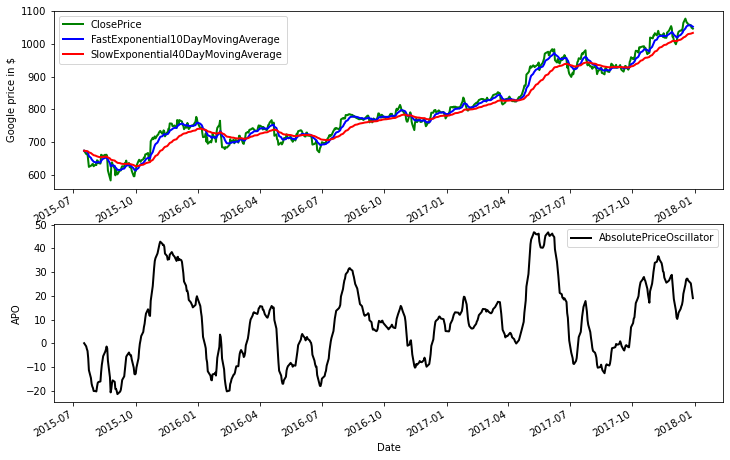

In [49]:
fig = plt.figure()
ax1 = fig.add_subplot(211, ylabel='Google price in $')

close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema_f.plot(ax=ax1, color='b', lw=2., legend=True)
ema_s.plot(ax=ax1, color='r', lw=2., legend=True)

ax2 = fig.add_subplot(212, ylabel='APO')
apo.plot(ax=ax2, color='black', lw=2., legend=True)

zoom = 2.0
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

plt.show()

### Implementation of the Moving Average Convergence Divergence (MACD):
MACD also relies on EMA:

$ MACD = EMA_{fast} - EMA_{slow} $

$ MACD_{Signal} = EMA_{MACD} $

$ MACD_{Histogram} = MACD - MACD_{Signal} $

In [50]:
num_periods_fast = 10 # fast EMA time period
K_fast = 2 / (num_periods_fast + 1) # fast EMA smoothing factor
ema_fast = 0
num_periods_slow = 40 # slow EMA time period
K_slow = 2 / (num_periods_slow + 1) # slow EMA smoothing factor
ema_slow = 0
num_periods_macd = 20 # MACD EMA time period
K_macd = 2 / (num_periods_macd + 1) # MACD EMA smoothing factor
ema_macd = 0

ema_fast_values = [] # track fast EMA values for visualization purposes
ema_slow_values = [] # track slow EMA values for visualization purposes
macd_values = [] # track MACD values for visualization purposes
macd_signal_values = [] # MACD EMA values tracker
macd_historgram_values = [] # MACD - MACD-EMA
for close_price in close:
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_fast + ema_fast
        ema_slow = (close_price - ema_slow) * K_slow + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    macd = ema_fast - ema_slow # MACD is fast_MA - slow_EMA
    if ema_macd == 0:
        ema_macd = macd
    else:
        ema_macd = (macd - ema_macd) * K_slow + ema_macd # signal is EMA of MACD values

    macd_values.append(macd)
    macd_signal_values.append(ema_macd)
    macd_historgram_values.append(macd - ema_macd)

In [51]:
goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=goog_data.index))
goog_data = goog_data.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=goog_data.index))
goog_data = goog_data.assign(MovingAverageConvergenceDivergence=pd.Series(macd_values, index=goog_data.index))
goog_data = goog_data.assign(Exponential20DayMovingAverageOfMACD=pd.Series(macd_signal_values, index=goog_data.index))
goog_data = goog_data.assign(MACDHistorgram=pd.Series(macd_historgram_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
ema_f = goog_data['FastExponential10DayMovingAverage']
ema_s = goog_data['SlowExponential40DayMovingAverage']
macd = goog_data['MovingAverageConvergenceDivergence']
ema_macd = goog_data['Exponential20DayMovingAverageOfMACD']
macd_histogram = goog_data['MACDHistorgram']

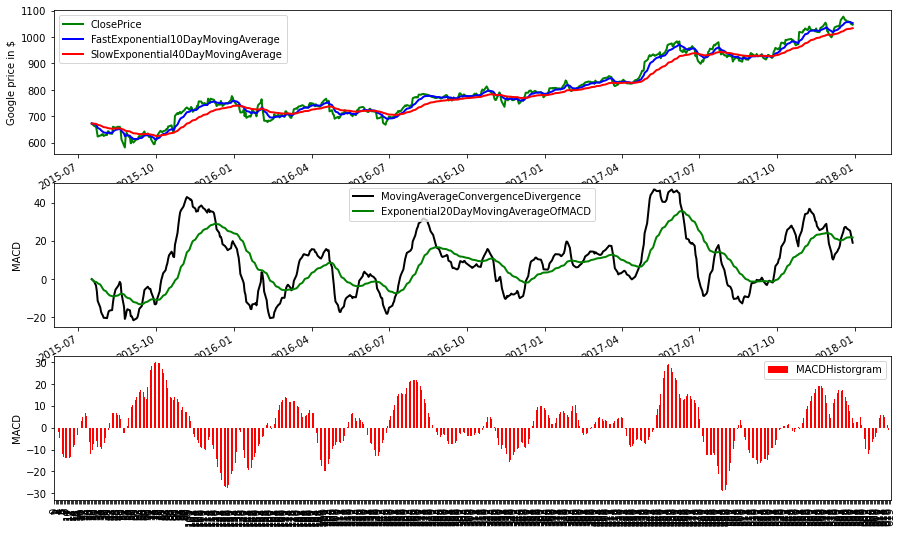

In [52]:
fig = plt.figure()
ax1 = fig.add_subplot(311, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema_f.plot(ax=ax1, color='b', lw=2., legend=True)
ema_s.plot(ax=ax1, color='r', lw=2., legend=True)
ax2 = fig.add_subplot(312, ylabel='MACD')
macd.plot(ax=ax2, color='black', lw=2., legend=True)
ema_macd.plot(ax=ax2, color='g', lw=2., legend=True)
ax3 = fig.add_subplot(313, ylabel='MACD')
macd_histogram.plot(ax=ax3, color='r', kind='bar', legend=True, use_index=False)

zoom = 2.5
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

plt.show()

### Implementation of Bollinger Bands (BBANDS):
BBANDS is also built on top of moving averages:

$ BBAND_{Middle} = SMA_{nperiods} $

$ BBAND_{Upper} = BBAND_{Middle} + (\beta*\sigma) $

$ BBAND_{Lower} = BBAND_{Middle} - (\beta*\sigma) $

$ \beta $: is a control paramenter, controls the width of our trading signal.

$ \sigma $: is the standard deviation.

In [53]:
import math as math

In [59]:
time_period = 20 # history length for Simple Moving Average for middle band
stdev_factor = 2 # Standard Deviation Scaling factor for the upper and lower bands
history = [] # price history for computing simple moving average
sma_values = [] # moving average of prices for visualization purposes
upper_band = [] # upper band values
lower_band = [] # lower band values

for close_price in close:
    history.append(close_price)
    if len(history) > time_period: # we only want to maintain at most 'time_period' number of price observations
        del (history[0])

    sma = stats.mean(history)
    sma_values.append(sma) # simple moving average or middle band
    variance = 0 # variance is the square of standard deviation
    for hist_price in history:
        variance = variance + ((hist_price - sma) ** 2)

    stdev = math.sqrt(variance / len(history)) # use square root to get standard deviation

    upper_band.append(sma + stdev_factor * stdev)
    lower_band.append(sma - stdev_factor * stdev)

In [58]:
goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(MiddleBollingerBand20DaySMA=pd.Series(sma_values, index=goog_data.index))
goog_data = goog_data.assign(UpperBollingerBand20DaySMA2StdevFactor=pd.Series(upper_band, index=goog_data.index))
goog_data = goog_data.assign(LowerBollingerBand20DaySMA2StdevFactor=pd.Series(lower_band, index=goog_data.index))

close_price = goog_data['ClosePrice']
mband = goog_data['MiddleBollingerBand20DaySMA']
uband = goog_data['UpperBollingerBand20DaySMA2StdevFactor']
lband = goog_data['LowerBollingerBand20DaySMA2StdevFactor']

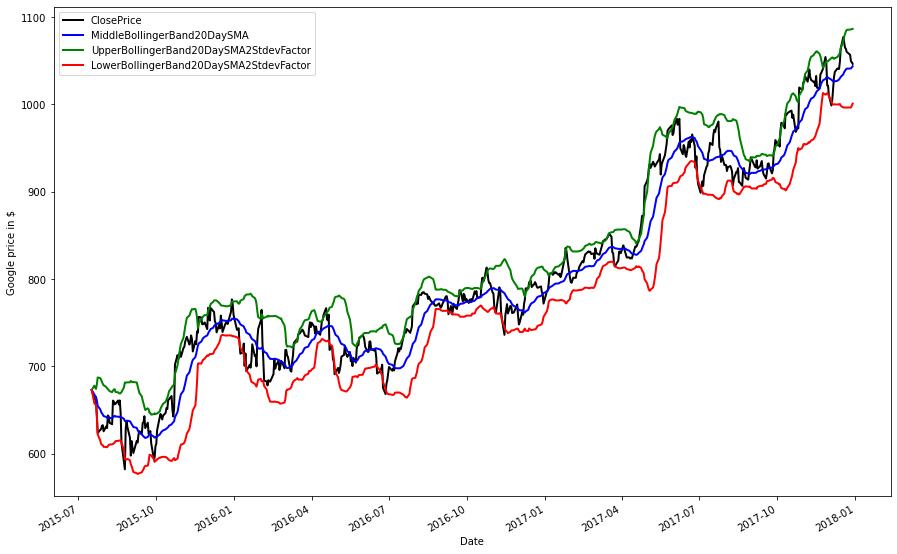

In [57]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close_price.plot(ax=ax1, color='black', lw=2., legend=True)
mband.plot(ax=ax1, color='b', lw=2., legend=True)
uband.plot(ax=ax1, color='g', lw=2., legend=True)
lband.plot(ax=ax1, color='r', lw=2., legend=True)

zoom = 2.5
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

plt.show()

### Implementation of the Relative Strength Indicator (RSI):

In [61]:
time_period = 20 # look back period to compute gains & losses
gain_history = [] # history of gains over look back period (0 if no gain, magnitude of gain if gain)
loss_history = [] # history of losses over look back period (0 if no loss, magnitude of loss if loss)
avg_gain_values = [] # track avg gains for visualization purposes
avg_loss_values = [] # track avg losses for visualization purposes
rsi_values = [] # track computed RSI values
last_price = 0 # current_price - last_price > 0 => gain. current_price - last_price < 0 => loss.

for close_price in close:
    if last_price == 0:
        last_price = close_price

    gain_history.append(max(0, close_price - last_price))
    loss_history.append(max(0, last_price - close_price))
    last_price = close_price

    if len(gain_history) > time_period: # maximum observations is equal to lookback period
        del (gain_history[0])
        del (loss_history[0])

    avg_gain = stats.mean(gain_history) # average gain over lookback period
    avg_loss = stats.mean(loss_history) # average loss over lookback period

    avg_gain_values.append(avg_gain)
    avg_loss_values.append(avg_loss)

    rs = 0
    if avg_loss > 0: # to avoid division by 0, which is undefined
        rs = avg_gain / avg_loss

    rsi = 100 - (100 / (1 + rs))
    rsi_values.append(rsi)

In [62]:
goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(RelativeStrengthAvgGainOver20Days=pd.Series(avg_gain_values, index=goog_data.index))
goog_data = goog_data.assign(RelativeStrengthAvgLossOver20Days=pd.Series(avg_loss_values, index=goog_data.index))
goog_data = goog_data.assign(RelativeStrengthIndicatorOver20Days=pd.Series(rsi_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
rs_gain = goog_data['RelativeStrengthAvgGainOver20Days']
rs_loss = goog_data['RelativeStrengthAvgLossOver20Days']
rsi = goog_data['RelativeStrengthIndicatorOver20Days']

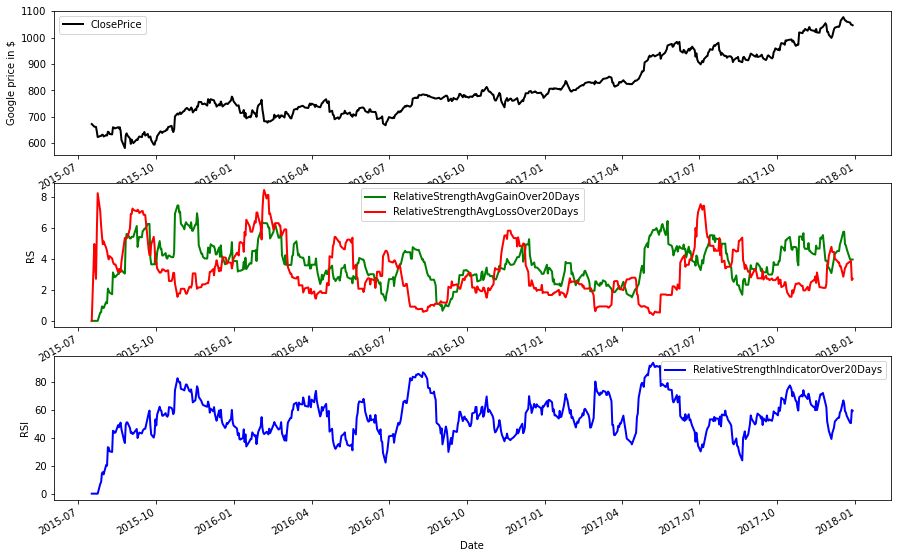

In [64]:
fig = plt.figure()
ax1 = fig.add_subplot(311, ylabel='Google price in $')
close_price.plot(ax=ax1, color='black', lw=2., legend=True)
ax2 = fig.add_subplot(312, ylabel='RS')
rs_gain.plot(ax=ax2, color='g', lw=2., legend=True)
rs_loss.plot(ax=ax2, color='r', lw=2., legend=True)
ax3 = fig.add_subplot(313, ylabel='RSI')
rsi.plot(ax=ax3, color='b', lw=2., legend=True)

zoom = 2.5
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

plt.show()

In [ ]:
print('uhuu')